## Importing libraries

In [1]:
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import powerlaw

#### the list of all airlines (open source dataset)

In [2]:
airports_ext = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/OpenFlights/airports.csv')
airports_ext = airports_ext.iloc[:,:9]
airports_ext.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


#### the list of all airports (open source dataset)

In [3]:
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()


In [4]:
airports = fr_api.get_airports()

In [5]:
airports = pd.DataFrame(airports)
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


In [428]:
airports = airports.dropna()

In [6]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5041 entries, 0 to 5040
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     5041 non-null   object 
 1   iata     5041 non-null   object 
 2   icao     5041 non-null   object 
 3   lat      5041 non-null   float64
 4   lon      5041 non-null   float64
 5   country  5041 non-null   object 
 6   alt      5041 non-null   object 
dtypes: float64(2), object(5)
memory usage: 275.8+ KB


#### Africa airports

In [7]:
# Define the latitude and longitude ranges for Africa
lat_min = -36.92
lat_max = 37.30
long_min = -28.60
long_max = 51.64


# Filter the DataFrame to only include locations within the boundaries
airports_afr = airports[(airports['lat'] >= lat_min) & (airports['lat'] <= lat_max) &
        (airports['lon'] >= long_min) & (airports['lon'] <= long_max)]

In [8]:
# List of countries to remove
countries_to_remove = ['Portugal', 'Italy','Spain','Greece','Turkey','Cyprus','Malta']

# Create a Boolean mask that identifies the rows to be removed
mask = airports_afr['country'].isin(countries_to_remove)

# Drop the rows identified by the Boolean mask
airports_afr = airports_afr[~mask]


In [76]:
import folium

# Define the center point for the map
center_lat = (lat_min + lat_max) / 2
center_long = (long_min + long_max) / 2

# Create a map centered on the defined center point
m = folium.Map(location=[center_lat, center_long], zoom_start=3)

# Add a rectangle to the map to represent the boundaries
folium.Rectangle(
    bounds = [[lat_min, long_min], [lat_max, long_max]],
    color='orange',
    fill= False
).add_to(m)

# Add markers for each airport in the DataFrame
for index, row in airports_afr.iterrows():
   if lat_min <= row['lat'] <= lat_max and long_min <= row['lon'] <= long_max:
        radius = 2  # Change the radius to adjust the size of the dots
        color = 'orange'  # Change the color of the dots
        fill_color = 'orange'  # Change the fill color of the dots
        fill_opacity = 0.2  # Change the fill opacity of the dots
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            color=color,
            fill_color=fill_color,
            fill_opacity=fill_opacity,
            tooltip=row['name']
        ).add_to(m)

# Show the map
m

In [10]:
airports_afr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 6 to 5038
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     417 non-null    object 
 1   iata     417 non-null    object 
 2   icao     417 non-null    object 
 3   lat      417 non-null    float64
 4   lon      417 non-null    float64
 5   country  417 non-null    object 
 6   alt      417 non-null    object 
dtypes: float64(2), object(5)
memory usage: 26.1+ KB


# THE CODE FOR OBTAINING SCHEDULES

In [17]:
import pandas as pd
from tqdm import tqdm
import requests
import json

# Replace [API_KEY] with your own API key
API_KEY = '____'

# Define the start and end dates
start_date = '2023-01-21'
end_date = '2023-01-28'

airport_codes= list(airports_afr['iata'].unique())

# Initialize an empty list to store the API responses
responses = []

# Loop over the list of airport codes
for airport in tqdm(airport_codes, desc='Getting timetable'):
    # Make a GET request to the API
    url = f'https://aviation-edge.com/v2/public/flightsHistory?key={API_KEY}&code={airport}&type=departure&date_from={start_date}&date_to={end_date}'
    response = requests.get(url,timeout=30)
    
    # Add the API response to the list
    try:
        responses.append(response.json())
    except json.JSONDecodeError as e:
        print(f'Error decoding JSON response for {airport}: {e}')

Getting timetable: 100%|██████████████████████| 417/417 [04:01<00:00,  1.72it/s]


In [18]:
responses

KeyboardInterrupt: 

In [19]:
df_list = []
for sublist in responses:
    try:
        df_list.append(pd.DataFrame(sublist))
    except ValueError as e:
        print("Error while converting JSON to dataframe:", e)

df = pd.concat(df_list)

Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, 

In [23]:
#df= df.drop(columns ='codeshared')
df = df.reset_index(drop=True)
df.head()

,status,departure,arrival,airline,flight,codeshared
0,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN
1,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN
2,unknown,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN
3,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN
4,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78311 entries, 0 to 78310
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   status      78311 non-null  object
 1   departure   78311 non-null  object
 2   arrival     78311 non-null  object
 3   airline     78311 non-null  object
 4   flight      78311 non-null  object
 5   codeshared  28070 non-null  object
dtypes: object(6)
memory usage: 3.6+ MB


In [26]:
# Use pandas.json_normalize() to extract the values from the dictionaries
departures = pd.json_normalize(df['departure'])

# Rename the columns to include 'departure' and the dictionary key
departures.columns = ['departure_' + col for col in departures.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([df, departures], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('departure', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_icaoCode,departure_scheduledTime,departure_delay,departure_actualTime,departure_estimatedRunway,departure_actualRunway,departure_estimatedTime,departure_terminal,departure_gate
0,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,oiaa,2023-01-21t03:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,oiaa,2023-01-21t18:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,"{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,oiaa,2023-01-21t19:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,oiaa,2023-01-21t22:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,oiaa,2023-01-21t23:30:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
ndf = ndf.drop(columns = ['departure_icaoCode','departure_actualTime', 'departure_estimatedRunway' , 'departure_actualRunway', 'departure_terminal' , 'departure_gate', 'departure_estimatedTime'])
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay
0,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN
1,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN
2,unknown,"{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN
3,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN
4,active,"{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN


In [28]:
# Use pandas.json_normalize() to extract the values from the dictionaries
arrivals = pd.json_normalize(ndf['arrival'])

# Rename the columns to include 'arrival' and the dictionary key
arrivals.columns = ['arrival_' + col for col in arrivals.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, arrivals], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('arrival', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_icaoCode,arrival_terminal,arrival_scheduledTime,arrival_estimatedTime,arrival_baggage,arrival_delay,arrival_gate,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway
0,active,"{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,oiii,2,2023-01-21t05:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,oiii,NaN,2023-01-21t20:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,oifm,NaN,2023-01-21t20:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,oiii,4,2023-01-22t00:15:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,oimm,NaN,2023-01-22t01:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ndf = ndf.drop(columns = [ 'arrival_icaoCode' , 'arrival_terminal', 'arrival_baggage' ,'arrival_actualTime', 'arrival_estimatedTime', 'arrival_estimatedRunway','arrival_actualRunway','arrival_gate'])
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay
0,active,"{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN
1,active,"{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN
2,unknown,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN
3,active,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN
4,active,"{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN


In [30]:
# Use pandas.json_normalize() to extract the values from the dictionaries
airlines = pd.json_normalize(ndf['airline'])

# Rename the columns to include 'airline' and the dictionary key
airlines.columns = ['airline_' + col for col in airlines.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, airlines], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('airline', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,airline_icaoCode
0,active,"{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,vrh
1,active,"{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,qsm
2,unknown,"{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,irc
3,active,"{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,irc
4,active,"{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,shi


In [31]:
ndf = ndf.drop(columns = [ 'airline_icaoCode'])


In [32]:
# Use pandas.json_normalize() to extract the values from the dictionaries
flights = pd.json_normalize(ndf['flight'])

# Rename the columns to include 'flight' and the dictionary key
flights.columns = ['flight_' + col for col in flights.columns]

# Concatenate the original DataFrame and the new flights DataFrame
ndf = pd.concat([ndf, flights], axis=1)

# Drop the original 'flights' column
ndf = ndf.drop('flight', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,flight_icaoNumber
0,active,NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,vrh5875
1,active,NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,qsm1217
2,unknown,NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,irc3758
3,active,NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,irc3751
4,active,NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,shi4367


In [33]:
ndf = ndf.drop(columns = ['flight_icaoNumber'])
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber
0,active,NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,
1,active,NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217
2,unknown,NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758
3,active,NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751
4,active,NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367


In [34]:
# Use pandas.json_normalize() to extract the values from the dictionaries
codeshared = pd.json_normalize(ndf['codeshared'])

# Rename the columns to include 'codeshared' and the dictionary key
codeshared.columns = ['codeshared_' + col for col in codeshared.columns]

# Concatenate the original DataFrame and the new codeshared DataFrame
ndf = pd.concat([ndf, codeshared], axis=1)

# Drop the original 'codeshared' column
ndf = ndf.drop('codeshared', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_airline.iataCode,codeshared_airline.icaoCode,codeshared_flight.number,codeshared_flight.iataNumber,codeshared_flight.icaoNumber
0,active,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,NaN,NaN,NaN,NaN,NaN,NaN
1,active,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,NaN,NaN,NaN,NaN,NaN,NaN
3,active,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,NaN,NaN,NaN,NaN,NaN,NaN
4,active,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
ndf = ndf.drop(columns = [ 'codeshared_airline.iataCode','codeshared_airline.icaoCode','codeshared_flight.number','codeshared_flight.icaoNumber'])
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,NaN,NaN
1,active,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,NaN,NaN
2,unknown,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,NaN,NaN
3,active,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,NaN,NaN
4,active,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,NaN,NaN


In [36]:
ndf.loc[ndf['codeshared_airline.name'].isnull(), 'codeshared_airline.name'] = ndf.loc[ndf['codeshared_airline.name'].isnull(), 'airline_name']
ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'codeshared_flight.iataNumber'] = ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'flight_iataNumber']
ndf['departure_delay'].fillna(0, inplace=True)


In [37]:
ndf.loc[ndf['arrival_delay'].isnull(), 'arrival_delay'] = ndf.loc[ndf['arrival_delay'].isnull(), 'departure_delay']
ndf[['departure_iataCode', 'arrival_iataCode']] = ndf[['departure_iataCode', 'arrival_iataCode']].applymap(str.upper)

In [38]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78311 entries, 0 to 78310
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        78311 non-null  object 
 1   departure_iataCode            78311 non-null  object 
 2   departure_scheduledTime       78311 non-null  object 
 3   departure_delay               78311 non-null  float64
 4   arrival_iataCode              78311 non-null  object 
 5   arrival_scheduledTime         78311 non-null  object 
 6   arrival_delay                 78311 non-null  float64
 7   airline_name                  78311 non-null  object 
 8   airline_iataCode              78311 non-null  object 
 9   flight_number                 78311 non-null  object 
 10  flight_iataNumber             78311 non-null  object 
 11  codeshared_airline.name       78311 non-null  object 
 12  codeshared_flight.iataNumber  78311 non-null  object 
dtypes

In [39]:
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,ABD,2023-01-21t03:45:00.000,0.0,THR,2023-01-21t05:00:00.000,0.0,varesh airlines,,5875,,varesh airlines,
1,active,ABD,2023-01-21t18:45:00.000,0.0,THR,2023-01-21t20:00:00.000,0.0,qeshm airlines,qb,1217,qb1217,qeshm airlines,qb1217
2,unknown,ABD,2023-01-21t19:50:00.000,0.0,IFN,2023-01-21t20:45:00.000,0.0,iran aseman airlines,ep,3758,ep3758,iran aseman airlines,ep3758
3,active,ABD,2023-01-21t22:45:00.000,0.0,THR,2023-01-22t00:15:00.000,0.0,iran aseman airlines,ep,3751,ep3751,iran aseman airlines,ep3751
4,active,ABD,2023-01-21t23:30:00.000,0.0,MHD,2023-01-22t01:00:00.000,0.0,sepehran airlines,is,4367,is4367,sepehran airlines,is4367


# ANALYSIS PART

In [43]:
ndf = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/codeshared/allflights23africa21012801.csv')

In [44]:
eur_g1 = ndf[ndf['flight_iataNumber'] == ndf['codeshared_flight.iataNumber']]

In [45]:
eur_g1 = eur_g1[eur_g1['status'] == 'active']

In [46]:
eur_g1 = eur_g1.drop_duplicates(subset=['departure_iataCode', 'departure_scheduledTime', 'arrival_iataCode'])

In [47]:
eur_g = eur_g1.drop(columns = ['status','departure_scheduledTime','departure_delay','flight_iataNumber','arrival_scheduledTime','arrival_delay','airline_iataCode','flight_number','codeshared_airline.name','codeshared_flight.iataNumber'])

In [48]:
eur_g = eur_g[eur_g['departure_iataCode'] != eur_g['arrival_iataCode']]


In [50]:
df_grouped = eur_g.groupby(eur_g.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.sort_values('counts', ascending=False).head(20)

,departure_iataCode,arrival_iataCode,airline_name,counts
5461,RUH,JED,saudia,151
3397,JED,RUH,saudia,142
3492,JNB,DUR,safair,135
2425,DUR,JNB,safair,135
3483,JNB,CPT,safair,128
1789,CPT,JNB,safair,128
5459,RUH,JED,flyadeal,117
3395,JED,RUH,flyadeal,113
1180,BJR,ADD,ethiopian airlines,104
259,ADD,BJR,ethiopian airlines,103


In [51]:
df_grouped['counts'] = round(df_grouped['counts']/7)


In [52]:
dflights_j =  df_grouped.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [53]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,departure_iataCode,arrival_iataCode,airline_name,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
0,AAE,ALG,air algerie,4.0,220,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,16
1,AAE,ALG,tassili airlines,0.0,220,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,16
2,AAE,CDG,air algerie,0.0,220,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,16
3,AAE,CDG,asl airlines ireland,0.0,220,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,16
4,AAE,ELU,tassili airlines,0.0,220,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,16


In [54]:
dflights_j = dflights_j.loc[:,['Airport ID','departure_iataCode','arrival_iataCode','Name','City','Country','Latitude','Longitude','airline_name','counts']]
dflights_j = dflights_j.rename(columns={"City": "City_origin", "Latitude":"Latitude_origin", "Longitude": "Longitude_origin", 'Country':'Country_origin','Name':'Name_origin','departure':'code_origin','arrival':'code_dest'})
dflights_j.head()

,Airport ID,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts
0,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,air algerie,4.0
1,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,tassili airlines,0.0
2,220,AAE,CDG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,air algerie,0.0
3,220,AAE,CDG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,asl airlines ireland,0.0
4,220,AAE,ELU,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,tassili airlines,0.0


In [56]:
dflights_j =  dflights_j.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,air algerie,4.0,210,Houari Boumediene Airport,Algier,Algeria,ALG,DAAG,36.691002,3.21541,82
1,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,ALG,DAAG,36.691002,3.21541,82
2,253,ABJ,ALG,Port Bouet Airport,Abidjan,Cote d'Ivoire,5.261390,-3.926290,air algerie,0.0,210,Houari Boumediene Airport,Algier,Algeria,ALG,DAAG,36.691002,3.21541,82
3,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,air algerie,2.0,210,Houari Boumediene Airport,Algier,Algeria,ALG,DAAG,36.691002,3.21541,82
4,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,ALG,DAAG,36.691002,3.21541,82


In [57]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,Latitude,Longitude,Altitude
0,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,air algerie,4.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
1,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
2,253,ABJ,ALG,Port Bouet Airport,Abidjan,Cote d'Ivoire,5.261390,-3.926290,air algerie,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
3,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,air algerie,2.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
4,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82


In [58]:
dflights_j = dflights_j.rename(columns={"City": "City_dest", "Latitude":"Latitude_dest", "Longitude": "Longitude_dest", 'Country':'Country_dest','Name':'Name_dest'})
dflights_j.head()


,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
0,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,air algerie,4.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
1,220,AAE,ALG,Rabah Bitat Airport,Annaba,Algeria,36.822201,7.809174,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
2,253,ABJ,ALG,Port Bouet Airport,Abidjan,Cote d'Ivoire,5.261390,-3.926290,air algerie,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
3,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,air algerie,2.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82
4,234,AZR,ALG,Touat Cheikh Sidi Mohamed Belkebir Airport,Adrar,Algeria,27.837601,-0.186414,tassili airlines,0.0,210,Houari Boumediene Airport,Algier,Algeria,36.691002,3.21541,82


In [59]:
dflights_j.to_csv('/Users/vladislavluksha/TESI DI LAUREA/flights_africa2023january.csv', index=False)

In [60]:
dflights_j.sort_values(by="counts",ascending= False).head(20)

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
1654,2082,RUH,JED,King Khaled International Airport,Riyadh,Saudi Arabia,24.957600,46.698799,saudia,22.0,2072,King Abdulaziz International Airport,Jeddah,Saudi Arabia,21.679600,39.156502,48
1725,2072,JED,RUH,King Abdulaziz International Airport,Jeddah,Saudi Arabia,21.679600,39.156502,saudia,20.0,2082,King Khaled International Airport,Riyadh,Saudi Arabia,24.957600,46.698799,2049
5224,813,JNB,DUR,OR Tambo International Airport,Johannesburg,South Africa,-26.139200,28.246000,safair,19.0,799,King Shaka International Airport,Durban,South Africa,-29.614444,31.119722,295
2487,799,DUR,JNB,King Shaka International Airport,Durban,South Africa,-29.614444,31.119722,safair,19.0,813,OR Tambo International Airport,Johannesburg,South Africa,-26.139200,28.246000,5558
2871,813,JNB,CPT,OR Tambo International Airport,Johannesburg,South Africa,-26.139200,28.246000,safair,18.0,797,Cape Town International Airport,Cape Town,South Africa,-33.964802,18.601700,151
2478,797,CPT,JNB,Cape Town International Airport,Cape Town,South Africa,-33.964802,18.601700,safair,18.0,813,OR Tambo International Airport,Johannesburg,South Africa,-26.139200,28.246000,5558
1652,2082,RUH,JED,King Khaled International Airport,Riyadh,Saudi Arabia,24.957600,46.698799,flyadeal,17.0,2072,King Abdulaziz International Airport,Jeddah,Saudi Arabia,21.679600,39.156502,48
1723,2072,JED,RUH,King Abdulaziz International Airport,Jeddah,Saudi Arabia,21.679600,39.156502,flyadeal,16.0,2082,King Khaled International Airport,Riyadh,Saudi Arabia,24.957600,46.698799,2049
2766,1107,ADD,BJR,Addis Ababa Bole International Airport,Addis Ababa,Ethiopia,8.977890,38.799301,ethiopian airlines,15.0,1111,Bahir Dar Airport,Bahar Dar,Ethiopia,11.608100,37.321602,5978
808,1111,BJR,ADD,Bahir Dar Airport,Bahar Dar,Ethiopia,11.608100,37.321602,ethiopian airlines,15.0,1107,Addis Ababa Bole International Airport,Addis Ababa,Ethiopia,8.977890,38.799301,7630


In [69]:
error_df = dflights_j[dflights_j['departure_iataCode'].isin(dflights_j['arrival_iataCode'].unique()) & ~dflights_j['arrival_iataCode'].isin(dflights_j['departure_iataCode'].unique())]
error_df = error_df[error_df['arrival_iataCode'].isin(airports_afr['iata'])]

# Create a new dataframe for the return flights
return_flights_df = error_df.copy()

# Swap the values in the appropriate columns to create the return flights
return_flights_df.rename(columns={
    'Airport ID_x': 'Airport ID_y',
    'Airport ID_y': 'Airport ID_x',
    'departure_iataCode': 'arrival_iataCode',
    'arrival_iataCode' : 'departure_iataCode',
    'Name_origin': 'Name_dest',
    'Name_dest': 'Name_origin',
    'City_origin': 'City_dest',
    'City_dest': 'City_origin',
    'Country_origin': 'Country_dest',
    'Country_dest': 'Country_origin',
    'Latitude_origin': 'Latitude_dest',
    'Latitude_dest': 'Latitude_origin',
    'Longitude_origin': 'Longitude_dest',
    'Longitude_dest': 'Longitude_origin',
    
}, inplace=True)

# Concatenate the existing dataframe and the return flights dataframe
new_df = pd.concat([dflights_j, return_flights_df], ignore_index=True)

# Save the new dataframe to a file or use it for further analysis
new_df.to_csv('AFRjanuary23.csv', index=False)

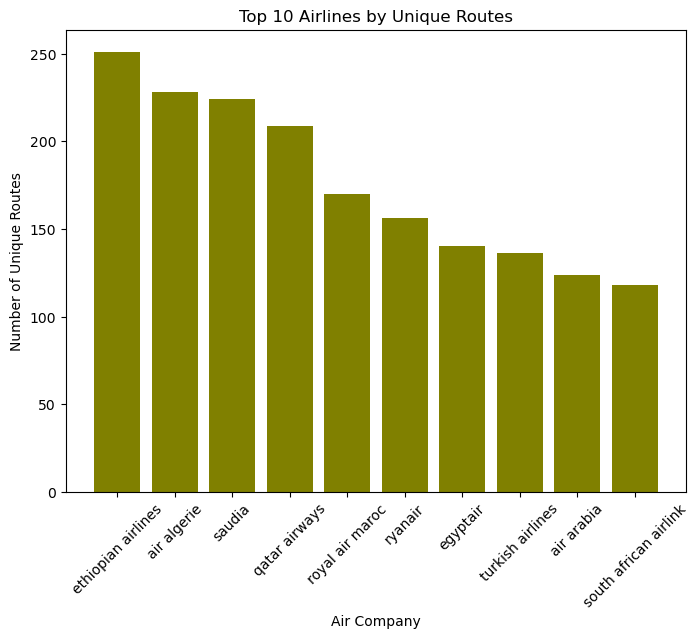

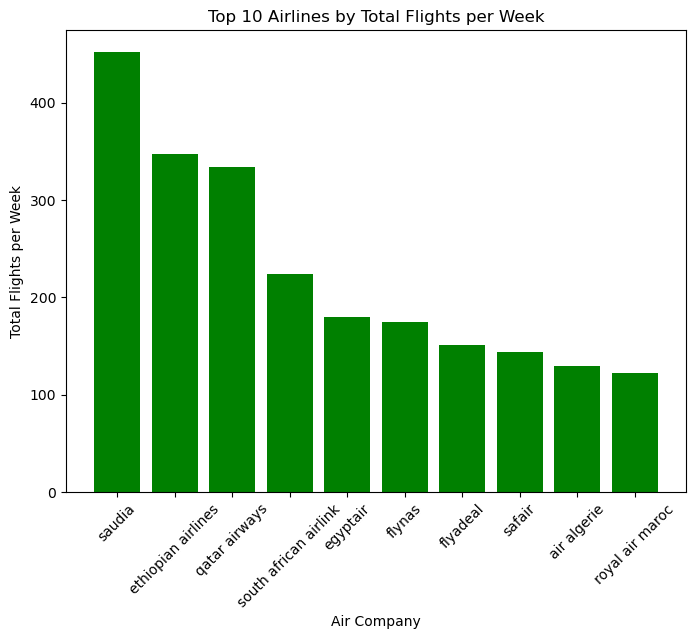

In [70]:
# Group the data by airline and count the number of unique routes for each airline
route_counts = new_df.groupby('airline_name').apply(lambda x: len(x[['departure_iataCode', 'arrival_iataCode']]))
route_counts = route_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the number of unique routes for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(route_counts.index, route_counts.values, color=['olive'])
ax.set_title('Top 10 Airlines by Unique Routes')
ax.set_xlabel('Air Company')
ax.set_ylabel('Number of Unique Routes')
plt.xticks(rotation=45)

# Group the data by airline and sum the number of flights for each airline
flight_counts = new_df.groupby('airline_name')['counts'].sum()
flight_counts = flight_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the total number of flights for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flight_counts.index, flight_counts.values, color=['green'])
ax.set_title('Top 10 Airlines by Total Flights per Week')
ax.set_xlabel('Air Company')
ax.set_ylabel('Total Flights per Week')
plt.xticks(rotation=45)

plt.show()

In [71]:
from math import radians, sin, cos, sqrt, atan2
def distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['Latitude_origin'])
    lon1 = radians(row['Longitude_origin'])
    lat2 = radians(row['Latitude_dest'])
    lon2 = radians(row['Longitude_dest'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance
new_df['distance'] = new_df.apply(distance, axis=1)

In [74]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    L.add_edge(origin, destination, weight= kilometers, airline_name =airline_name )


# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "graph2023_africa.gexf")

In [73]:
# Initialize the graph
F = nx.MultiDiGraph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    F.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    F.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    F.add_edge(origin, destination, weight=kilometers, airline_name=airline_name, number_flights = cnts)

# Write the graph to a file
nx.write_gexf(F, "fixed_graph2023_africa.gexf")


GRAPH ANALYSIS

In [75]:
print('Number of nodes: {} - Number of links: {}'.format(L.order(),L.size()))

Number of nodes: 726 - Number of links: 2864


Number of nodes: 1047 - Number of links: 11313
the density of a graph is a measure of how many edges are present in the graph relative to the total number of possible edges. It is calculated as the ratio of the actual number of edges to the total number of possible edges in the graph.

In [ ]:
L_density = nx.density(L)
print("Density: " + str(L_density))

In [ ]:
L_degree = list(dict(L.degree()).values())

In [ ]:
print("African Air Transportation Graph Degree statistics: ")
print("Mean: " + str(round(np.mean(L_degree),4)))
print("Median: " + str(np.median(L_degree))) 
print("Standard deviation: " + str(round(np.std(L_degree),4)))
print("Maximum: " + str(np.max(L_degree)))
print("Minimum: " + str(np.min(L_degree)))

Minimum degree is 1, so there as no isolated nodes. Mean value is higher that median, so we deal with a scale-free network. To verify this we will check degree distribution and compare it to the random network degree distribution
A scale-free network is a type of network where the distribution of node degrees (the number of connections per node) follows a power law. This means that a few nodes have a very high degree of connections, while most nodes have only a few connections.

In [ ]:
# ECDF in linear scale
cdf_function = ECDF(L_degree)
x = np.unique(L_degree)
y = cdf_function(x)

fig_cdf_function = plt.figure(figsize=(8, 4)) 
axes = fig_cdf_function.gca()

axes.plot(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree', size=15)
axes.set_ylabel('ECDF', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8, 4))
axes = fig_cdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECCDF in loglog scale
y = 1 - cdf_function(x)

fig_ccdf_function = plt.figure(figsize=(8, 4))
axes = fig_ccdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECCDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

In [ ]:
percentile_99 = np.percentile(L_degree,99)
print(percentile_99)

In [ ]:
#HUBS 

hub = [k for k,v in dict(L.degree()).items() if v>= percentile_99]
print('Number of hubs:',len(hub))
print('List of hubs:', list(hub))

print('Number of isolated nodes:', list(nx.isolates(L)))

In [ ]:
df_hubs = dflights_j[dflights_j['Airport ID_x'].isin(hub)]['City_origin'].unique()
print(df_hubs)

In [ ]:
print(nx.is_connected(L))
print(nx.number_connected_components(L))

In [ ]:
L_triangles_list = list(nx.triangles(L).values())

In [ ]:
# get the number of triangles for each node
triangles = nx.triangles(L)

# print the number of triangles for each node
for node, num_triangles in triangles.items():
    print(f"Node {node} is part of {num_triangles} triangles.")
    
    

In [ ]:
transitivity = nx.transitivity(L)
print(transitivity)

In [ ]:
print('g - average local clustering: {}'.format(nx.average_clustering(L)))

In [ ]:
print("Local Clustering Coefficient statistics (L): ")
print('European Network - mean local clustering: {}'.format(np.mean(list(nx.clustering(L).values()))))
print('European Network  - standard deviation local clustering: {}'.format(np.std(list(nx.clustering(L).values()))))
print('European Network  - median local clustering: {}'.format(np.median(list(nx.clustering(L).values()))))
print('European Network  - max local clustering: {}'.format(np.max(list(nx.clustering(L).values()))))
print('European Network  - min local clustering: {}'.format(np.min(list(nx.clustering(L).values()))))

In [ ]:
local_clustering_L = list(nx.clustering(L).values())

In [ ]:
print("Pearson coefficient and p-value between Degree and Clustering coefficient: ")
print(scipy.stats.pearsonr(L_degree, local_clustering_L))

In [ ]:
degree_centrality = nx.degree_centrality(L)
eigenvector_centrality = nx.eigenvector_centrality(L)
pr_centrality = nx.pagerank(L)

hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_pagerank = sorted(pr_centrality.items(),key = lambda x:x[1], reverse=True)[0]

print('degree:      ',hub_degree)
print('eigenvector: ',hub_eigenvector)
print('pagerank: ',hub_eigenvector)

In [ ]:
print("Pearson coefficient and p-value between Degree and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(eigenvector_centrality.values())))
print("Pearson coefficient and p-value between Degree and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(pr_centrality.values())))
print("Pearson coefficient and p-value between Eigenvector and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(eigenvector_centrality.values()),list(pr_centrality.values())))



In [ ]:

print("Spearman and Kendall coefficient between Degree and Eigenvector Centralities: ")
print(scipy.stats.spearmanr(list(degree_centrality.values()),list(eigenvector_centrality.values())))

print("Spearman and Kendall coefficient between Degree and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(degree_centrality.values()),list(pr_centrality.values())))

print("Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(eigenvector_centrality.values()),list(pr_centrality.values())))

In [ ]:
print("Degree assortativity: " + str(nx.degree_assortativity_coefficient(L)))

In [ ]:
partition_library = community_louvain.best_partition(L)

In [ ]:
print(set(partition_library.values()))

In [ ]:
nx.set_node_attributes(L, partition_library, "community_library")

In [ ]:
comms = set(partition_library.values())

In [ ]:
list_community_sets_library = [ set() for i in range(len(comms)) ]

In [ ]:
for n, comm in partition_library.items():
    list_community_sets_library[comm].add(n)

In [ ]:
#print("Coverage")
print("Coverage", nx_comm.coverage(L, list_community_sets_library))
#print("Modularity")
print("Modularity", nx_comm.modularity(L, list_community_sets_library, weight='weight'))
#print("Performance")
#print("Performance", nx_comm.performance(G, my_list))

Coverage is a measure of how well a given set of communities covers the nodes in a network. It is defined as the fraction of nodes that are assigned to at least one community. A higher coverage means that the communities are able to capture a larger fraction of the nodes in the network.

Modularity, on the other hand, measures the quality of a given partition of a network into communities. It is defined as the difference between the fraction of edges within communities and the expected fraction of edges within communities if the edges were distributed at random. A higher modularity means that the communities are more tightly connected with each other than expected by chance, indicating a stronger community structure in the network.

In [ ]:
pairs = []
for i, nodes in enumerate(list_community_sets_library):
    print(i,len(nodes))
    comm_size = (i,len(nodes))
    pairs.append(comm_size)

In [ ]:
community_index = []
number_of_nodes = []

for comm, n_nodes in pairs:
    community_index.append(str(comm))
    number_of_nodes.append(n_nodes) 

In [ ]:
plt.bar(community_index,number_of_nodes, color='purple')
plt.xlabel("Community")
plt.ylabel("Number of nodes")



In [ ]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)

In [ ]:
centr_comm = {}
# node -> centrality in the community subgraph

In [ ]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)
    subgraph.order()
    nx.degree_centrality(subgraph)
    
    node_degrees  = nx.degree_centrality(subgraph)
    for n,d in node_degrees.items():
        centr_comm[n] = d

In [ ]:
nx.set_node_attributes(L, centr_comm, "centr_comm")

In [ ]:
nx.has_bridges(L)